In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import re
import subprocess
import nltk
from nltk.tokenize import word_tokenize

from nltk.stem import  WordNetLemmatizer
# to download and unzip wordnet for the effective working of the lemmatizer
nltk.download('wordnet', download_dir='/kaggle/working/')
command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
subprocess.run(command.split())
nltk.data.path.append('/kaggle/working/')

from nltk.corpus import stopwords ,wordnet

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix


[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [3]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## EDA

Identifying missing values

In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

**Process of Lemmatization is used for more clarity on the base words**

In [8]:
lemmatizer = WordNetLemmatizer()
# User defined function for tokenising and cleaning the text 
def TokenizeandClean (review):
    '''
    The function returns the cleaned and lemmatized tokens of the text passed as argument.
    All the unncessary words are removed using the stopwords.
    arg : text to be cleaned.
    returns: cleaned text.
    '''
    review = re.sub('[^a-zA-Z]',' ',review)
    review = review.lower()
    review = word_tokenize(review)
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    return(review)

## Data Preprocessing

In [9]:
# The review feature in the dataset is preprocessed

df.review = df.review.apply(TokenizeandClean)

In [10]:
# the dataaset is split into X(independent) and Y(dependent) variables
X = df['review']
Y = df['sentiment']

### Splitting into training and testing datasets

In [11]:
# the dataset is split into training and testing datasets

xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

**Label Encode the sentiment feature**

In [12]:
# Encoding the labels after the train test split inorder to avoid data leakeage.

lab_encode = LabelEncoder()

ytrain = lab_encode.fit_transform(ytrain)
ytest = lab_encode.transform(ytest)

**The text has to be vectorized before feeding into the machine learning models.
TF-IDF Vectorizer is used for vectorization**

In [13]:
# train and test independent texts are converted into vectors
tf = TfidfVectorizer()

xtraintf = tf.fit_transform(xtrain)
xtesttf = tf.transform(xtest)

## Model Building

In [14]:
# models are placed in a dictionary mapping to their objects
models = {'logistic':LogisticRegression(random_state=42),
          'randomforest':RandomForestClassifier(random_state=42),
         'gradientboost':GradientBoostingClassifier(random_state=42),
         'mnaivebayes':MultinomialNB(),
         'xgboost':XGBClassifier(random_state=42)}


def model_build(xtrain,ytrain,xtest,ytest):
    '''
    The function trains the models with the training dataset, predicts the output sentiment, 
    calculates and returns the accuracy score, prints the confusion matrix and the 
    classification report.
    ========================================================================================
    args:
    x_training : training x set
    y_training : training y set
    x_testing  : testing x set
    y_true  : testing y set
    
    Returns an appended list of accuracies from all the models
    
    '''
    acc = []
    for model_name,model in models.items():
        model.fit(xtrain,ytrain)
        print(str.center(model_name,40),'\n',str.center('='*25,50))
        ypred = model.predict(xtest)
        acc.append(round(accuracy_score(ytest,ypred),2))
        print(confusion_matrix(ytest,ypred))
        print(classification_report(ytest,ypred))
    return acc  

In [15]:
# calling the function to build the models
# The function returns list of accuracies and is strored in a variable

accuracy_tf = model_build(xtraintf,ytrain,xtesttf,ytest)

                logistic                 
[[4373  588]
 [ 433 4606]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

              randomforest               
[[4266  695]
 [ 750 4289]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4961
           1       0.86      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

             gradientboost               
[[3795 1166]
 [ 671 4368]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.81      4961
           1       0.79      0

In [22]:
# The above list is stored in a dataframe
accdf = pd.DataFrame(accuracy_tf,index=list(models.keys()), columns=['accuracy'])
accdf = accdf.sort_values(by='accuracy')

<Axes: ylabel='accuracy'>

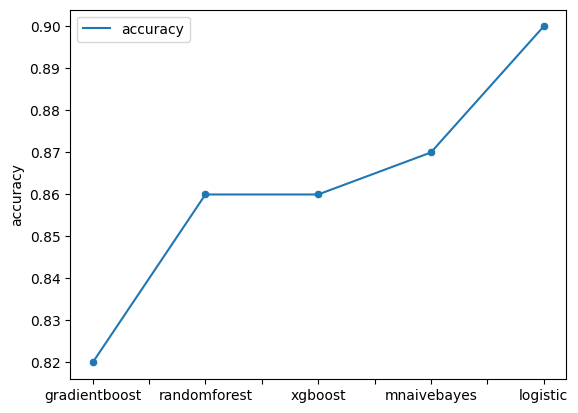

In [25]:
# The accuracies stored in the dataframe are then visualized using plot()
accdf.plot()
sns.scatterplot(accdf.accuracy)


###### After working the dataset with TF-IDF vectorizer, building the models, and by looking at the above graph, we can infer that
- we get better vectors with tf-idf vectorizer
- all the models gave above 80% accuracy but Logistic Regression gave us a score of 90%


### Conclusion

##### Logistic regression is the best model when coupled with TF-IDF Vectorizer 

In [27]:
#Testing our model with a real world review
msg = "Dark, bizzare, and hilarious, this comedy turns the high school odd-duck story on its \
ear with quirky character cut-ups, and over-the-top comedic moments. Great cast, soundtrack, \
and story, this movie was firing on all cylinders."

# tokenize and clean the review
msg = TokenizeandClean(msg)
# vectorize using tf idf
transformed_review = tf.transform([msg])
# predict the sentiment using logistic regression
ypredict = models['logistic'].predict(transformed_review)

# applying inverse transformimg on the predicted value to find the sentiment
lab_encode.inverse_transform(ypredict).item()



'positive'